In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

In [2]:
! head /home/zequnl/Projects/pixell_tutorials/camb_theory.dat

#    L    TT             EE             TE             PP             TP          
     2    0.10714E+04    0.35093E-01    0.28649E+01    0.10914E+07    0.29354E+05
     3    0.10137E+04    0.47709E-01    0.32848E+01    0.16776E+07    0.35007E+05
     4    0.95855E+03    0.44418E-01    0.31504E+01    0.21985E+07    0.37653E+05
     5    0.91688E+03    0.32250E-01    0.27441E+01    0.26584E+07    0.38687E+05
     6    0.88791E+03    0.19551E-01    0.22592E+01    0.30641E+07    0.38820E+05
     7    0.86904E+03    0.10795E-01    0.18062E+01    0.34237E+07    0.38439E+05
     8    0.85742E+03    0.63637E-02    0.14377E+01    0.37438E+07    0.37767E+05
     9    0.85149E+03    0.46348E-02    0.11715E+01    0.40301E+07    0.36935E+05
    10    0.84988E+03    0.39509E-02    0.10055E+01    0.42863E+07    0.36023E+05


In [3]:
from pixell import enmap, powspec
camb_theory = powspec.read_spectrum("/home/zequnl/Projects/pixell_tutorials/camb_theory.dat")

In [4]:
camb_theory[0,0,3]

530.7720788239956

In [25]:
shape,wcs = enmap.geometry(shape=(64, 128),
                           res=np.deg2rad(0.5/60.),pos=(0,0))
print(shape)

(64, 128)


In [26]:
noise_power = 1e-3

In [27]:
lmax = 10000

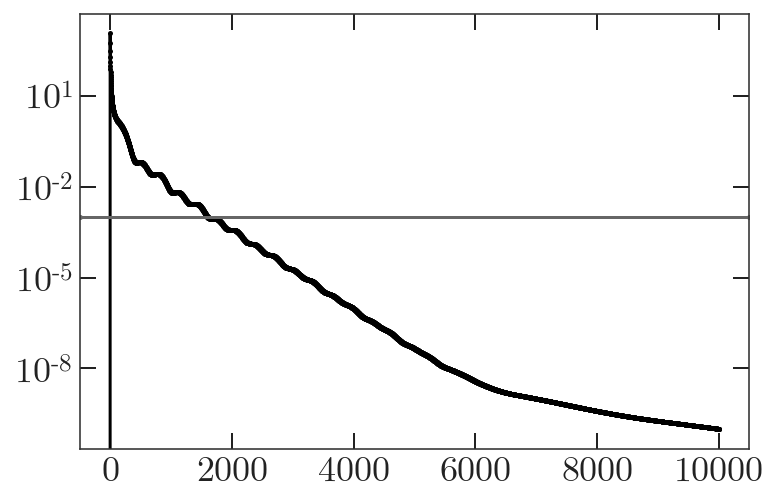

In [28]:
plt.plot(camb_theory[0,0,:lmax])
plt.axhline(1e-3)
plt.yscale('log')

/home/zequnl/anaconda3/envs/cosmology/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


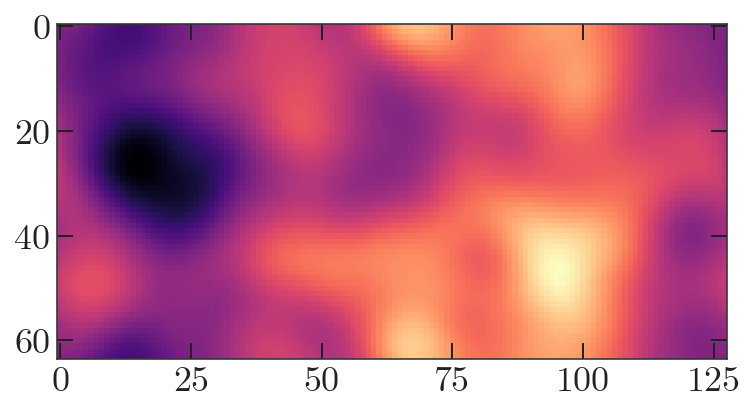

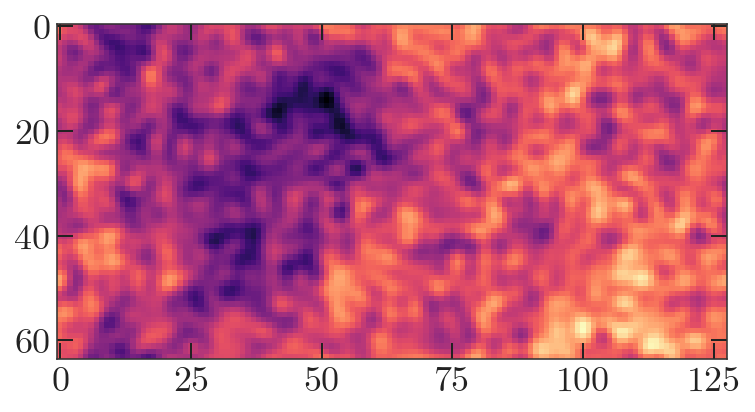

In [29]:
ells = np.arange(0,lmax,1)
ps = camb_theory[0,0,:lmax]
ps[:2] = 0.0
cmb = enmap.rand_map(shape,wcs,ps[np.newaxis,np.newaxis])

ells = np.arange(0,lmax,1)
ps = 1/ells**2.15
ps[:2] = 0
dust = enmap.rand_map(shape,wcs,ps[np.newaxis,np.newaxis])

plt.figure()
plt.imshow(cmb)
plt.figure()
plt.imshow(dust)

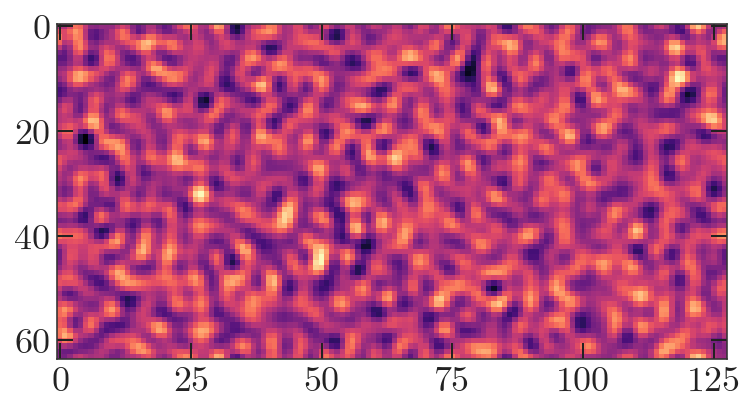

In [30]:
def get_noise_realization(nl):
    ells = np.arange(0,lmax,1)
    ps = np.ones_like(ells) * nl
    return enmap.rand_map(shape,wcs,ps[np.newaxis,np.newaxis])

plt.imshow(get_noise_realization(noise_power))

In [31]:
enmap.extent(cmb.shape, cmb.wcs, signed=True)/cmb.shape[-2:]

array([0.00014544, 0.00014544])

In [32]:
enmap.extent(cmb.shape, cmb.wcs, signed=True)

array([0.00930842, 0.01861678])

In [33]:
enmap.read_fits_geometry

<function pixell.enmap.read_fits_geometry(fname, hdu=None)>

In [34]:
3.14 / (180 / (0.5/60))

0.00014537037037037039

In [35]:
! rm ../data/*.fits

In [36]:
for freq in [90, 150, 220]:
    noise = get_noise_realization(noise_power)
    
    hits = np.random.randint(30, 100, shape)
    sigma = 1650.4
    noise_map = sigma / np.sqrt(hits)
    noise_realization = enmap.enmap( noise_map * np.random.randn(shape[0], shape[1]), wcs)
    
    enmap.write_fits(f'../data/hits_{freq}.fits', hits)
    enmap.write_fits(f'../data/noise_{freq}.fits', noise_map)
    enmap.write_fits(f'../data/cmb_{freq}.fits', cmb)
#     enmap.write_fits(f'../data/dust_{freq}.fits', dust * freq**2)
    enmap.write_fits(f'../data/tot_{freq}.fits',
                     cmb + noise_realization ) # dust * freq**2

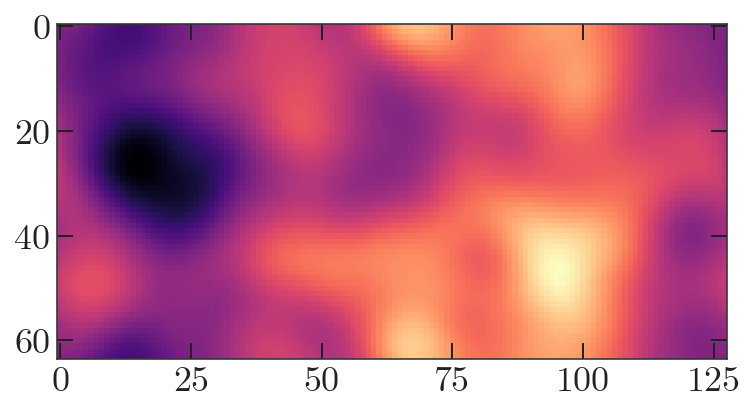

In [37]:
plt.imshow(cmb)

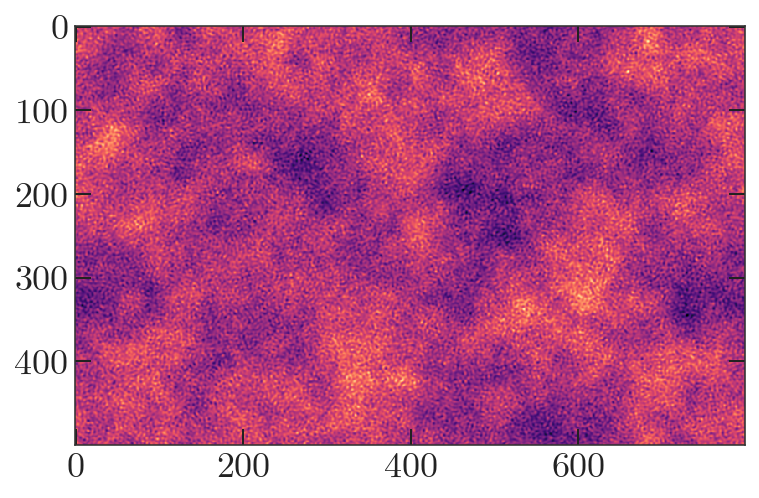

In [18]:
plt.imshow(cmb + noise)

In [19]:
def compute_ps(map1, map2):
    """Compute the FFTs, multiply, bin
    
    Beams are multiplied at bin centers.
    """
    kmap1 = enmap.fft(map1, normalize="phys")
    kmap2 = enmap.fft(map2, normalize="phys")
    power = (kmap1*np.conj(kmap2)).real
    
    bin_edges = np.arange(0,8000,40)
    centers = (bin_edges[1:] + bin_edges[:-1])/2.
    modlmap = enmap.modlmap(map1.shape,map1.wcs)
    binned_power = bin(power,modlmap,bin_edges)
    return centers, binned_power

In [20]:
def bin(data,modlmap,bin_edges):
    digitized = np.digitize(np.ndarray.flatten(modlmap), bin_edges,right=True)
    return np.bincount(digitized,(data).reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]


In [21]:
ell, pow = compute_ps(noise, noise)

/home/zequnl/anaconda3/envs/cosmology/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


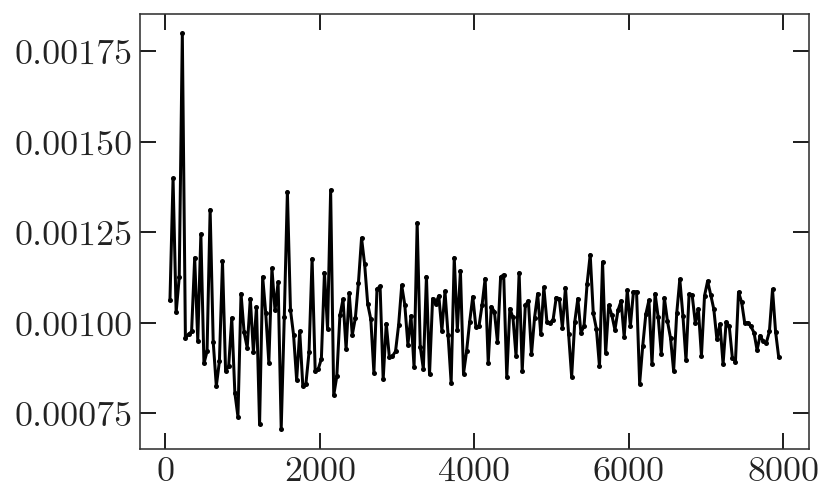

In [22]:
plt.plot(ell, pow)

In [23]:
# S1 = enmap.spec2flat(cmb.shape, cmb.wcs, np.ones( (1,1,len(Bl)) ) )
# S0 = enmap.spec2flat(cmb.shape, cmb.wcs, np.reshape(Bl, (1,1,len(Bl))) )

# B = ( np.abs( S0 / (S1 + 1e-16) ) ) # avoid infinities
# B1 = np.interp(x=enmap.modlmap(cmb.shape, cmb.wcs), 
#                xp=np.arange(len(Bl)), fp=Bl )

In [24]:
plt.plot( enmap.laxes(cmb.shape, cmb.wcs)[1], np.diag(B[0,0,:,:]) )
plt.plot( enmap.laxes(cmb.shape, cmb.wcs)[1], np.diag(B1) )
plt.xlim(-5000, 5000)

NameError: name 'B' is not defined

In [ ]:
plt.imshow(B[0,0,:,:])

In [ ]:
S = enmap.spec2flat(cmb.shape, cmb.wcs,camb_theory[:1,:1,:] )

In [ ]:
plt.plot(camb_theory[0, 0, :10000])
plt.plot( 2 * np.pi /  * np.arange(S.shape[-1]), np.diag((S[0,0,:,:])) )
plt.yscale("log")

In [ ]:
S = enmap.spec2flat(cmb.shape, cmb.wcs,camb_theory[:1,:1,:] * 0 + 1e-3 )

In [ ]:
S

In [ ]:
plt.imshow( np.log10(S[0,0,:,:]) )
plt.colorbar()

In [ ]:
import pixell.fft

In [ ]:
enmap.rand_map(shape,wcs,camb_theory).shape

In [ ]:
emap = enmap.enmap([[1,2,3],[3,4,5]], wcs=wcs)
print(enmap.fft( emap ))
enmap.ifft( enmap.fft( emap ) )

In [ ]:
ps = camb_theory[0,0,:lmax]
ps[:2] = 0.0

fftlist = [
    enmap.fft(enmap.rand_map(shape,wcs,ps[np.newaxis,np.newaxis]), 
                   nthread=16)
    for i in range(30)
]

In [ ]:
# abslist = [np.abs(f) for f in fftlist]

In [ ]:
errS = np.var( fftlist, axis=0 )

In [ ]:
px = enmap.enmap([[1,2,3],[3,4,5]], wcs=wcs).pixsize()

In [ ]:
plt.plot( np.log10(errS[0,:]) )
plt.plot( np.log10(S[0,0,0, :]) )

In [ ]:
import healpy as hp
Bl = hp.gauss_beam(np.pi * (10.0/60.0) / 180.0, lmax=10000)
plt.plot(Bl)

In [ ]:
plt.imshow( np.log10(errS), vmin=-3, vmax=8 )
plt.colorbar()